This notebook contains a short guide on using the solvers w/o backprop or computing gradients. Some issues of interest include:
1. How to define and solve SDEs with this codebase
1. How to run things on a GPU
1. How to gain control over the randomness and enforce deterministic behavior with fixed seeds (e.g. when testing)
1. The subtlety of noise type in SDEs

The other file in the `examples` folder (`latent_sde.py`) contains the use case where gradients need to be taken to fit parameters.

In [2]:
import torch
from torch import nn

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

from torchsde import sdeint, BrownianPath, BrownianTree

Just like how each ordinary differential equation (ODE) is governed by a vector field, a stochastic differential equation (SDE) is governed by two vector fields, which are called the **drift** and **diffusion** functions:
$$dx(t) = \underbrace{f(x(t), t, \theta_f)}_{\text{drift}} dt + \underbrace{g(x(t), t, \theta_g)}_{\text{diffusion}} dW(t).$$
The output of $f$ is of the same size as the $d$-dimensional state, whereas the output of $g$ may be a matrix of size $(d, m)$. 

Here, $W(t)$ is the Brownian motion (aka Wiener process), and it may be $m$ dimensional. It is a stochastic process, and each random draw produces a function of time. 

### 1. Solving a simple SDE
To implement an SDE, we create a class with the functions `f` and `g`:

In [2]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=False)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

The functions `f` and `g` are arbitrarily chosen for demonstration purposes. The attributes `noise_type` and `sde_type` are used in the solver to determine the particular numerical method being used and must be included. We use `diagonal` here, meaning the output of `g` should be a vector with the same shape as input `y`, and it is an element-wise function. 
Note that for any other noise type, we expect the output of `g` to be a matrix, and batch matrix-vector product is performed under the hood.
The requirement of element-wise function is a rather technical condition to ensure the high-order solvers attain their theoretically derived efficiency. 

All solvers in the codebase are based on [Itô stochastic integrals](https://en.wikipedia.org/wiki/It%C3%B4_calculus), so we use `ito` for the `sde_type` attribute. The library also has a base class `SDEIto`, which can be inherited from and imported directly, and saves the extra line of setting the `sde_type` attribute. As a side note, our adjoint computation internally computes a Stratonovich correction term and performs the reverse pass with it. We plan to add solvers based on stratonovich SDEs in the future.

Now we instantiate an object of the SDE class and call the function `sdeint` on it.

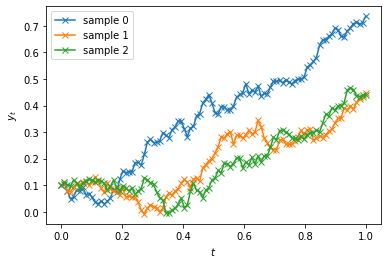

In [3]:
batch_size, d, T = 3, 1, 100
sde = SDE()
ts = torch.linspace(0, 1, T)
y0 = torch.zeros(batch_size, 1).fill_(0.1)  # (batch_size, d)

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='srk')  # (T, batch_size, d) = (100, 3, 1).

plt.figure()
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

`method='srk'` means the strong order 1.5 Stochastic Runge-Kutta (SRK) method is used. Other possible methods include the strong order 0.5 `euler` and strong order 1.0 `milstein`, both of which are of slightly lower order.

We stress that the drift and diffusion functions don't necessarily need to be defined as the `f` and `g` methods of the class. They can be methods with any name, so long as we provide these names to the solver when they differ from the default `f` and `g`. The following is an example where the function `h` is used as the drift.

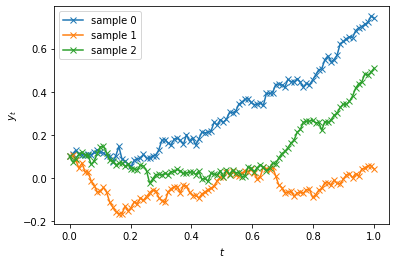

In [4]:
class SDENewName(nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=False)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def h(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))
    
sde_new_name = SDENewName()

with torch.no_grad():
    ys = sdeint(sde_new_name, y0, ts, method='srk', names={'drift': 'h'})  # Supply a dictionary to the argument `names`.

plt.figure()
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

### 2. Moving to GPUs
Trivially, the previous code may be adapted to run on GPUs, just by moving all tensors to a GPU:

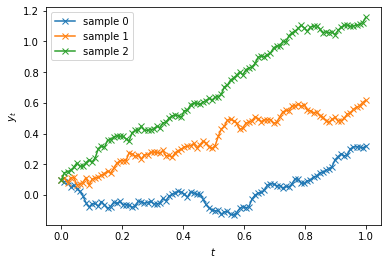

In [5]:
if torch.cuda.is_available():
    gpu = torch.device('cuda')
    sde = SDE().to(gpu)
    ts = ts.to(gpu)
    y0 = y0.to(gpu)
    with torch.no_grad():
        ys = sdeint(sde, y0, ts, method='srk')  # (100, 3, 1).

    plt.figure()
    for i in range(batch_size):
        plt.plot(ts.cpu(), ys[:, i].squeeze().cpu(), marker='x', label=f'sample {i}')
    plt.xlabel('$t$')
    plt.ylabel('$y_t$')
    plt.legend()
    plt.show()

A side note is that multi-GPU data parallel is possible with the existing codebase, but the use case has not been tried out extensively and may require defining non-standard SDE classes and methods. 

### 3. Explicit control over randomness from the Brownian motion
To gain control over the randomness, we draw Brownian motion samples by instantiating objects of classes `BrownianPath` or `BrownianTree`. `BrownianPath` has fast query, but stores all previous queries, so is costly in memory. `BrownianTree` only stores objects in a fixed size cache, but has slower query, since everything else is reconstructed on the fly based on random seed splitting. Repeated queries on the same Brownian motion object gives deterministic results. Here, we use `BrownianPath` as an example.

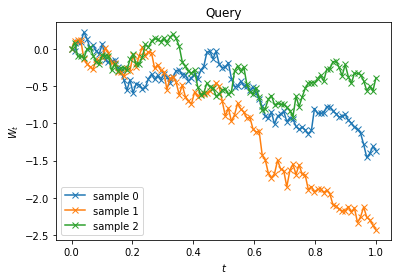

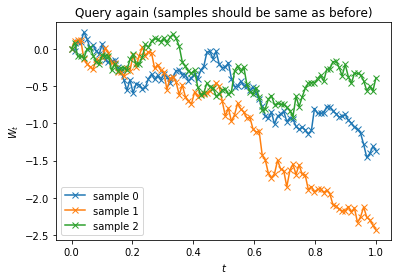

In [6]:
ts = torch.linspace(0, 1, T)
bm = BrownianPath(t0=0.0, w0=torch.zeros(batch_size, d))

bm_queries = torch.stack([bm(t) for t in ts], dim=0)
plt.figure()
plt.title('Query')
for i in range(batch_size):
    plt.plot(ts, bm_queries[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$W_t$')
plt.legend()
plt.show()

bm_queries2 = torch.stack([bm(t) for t in ts], dim=0)
plt.figure()
plt.title('Query again (samples should be same as before)')
for i in range(batch_size):
    plt.plot(ts, bm_queries2[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$W_t$')
plt.legend()
plt.show()

assert torch.allclose(bm_queries, bm_queries2)

In our experience, having the Brownian motion run on CPUs is usually slightly faster than having it run on GPUs (though, generally, this obviously depends on the specific hardware, software, and program). When the latter is necessary, we can achieve this by either putting `w0` on the GPU or using the `to` method of the `bm` object:

In [7]:
if torch.cuda.is_available():
    # Approach 1:
    bm = BrownianPath(t0=0.0, w0=torch.zeros(batch_size, d).to(gpu))  # Runs on GPU.
    print(bm(0.5))
    
    # Approach 2:
    bm = BrownianPath(t0=0.0, w0=torch.zeros(batch_size, d))  # Runs on CPU.
    bm.to(gpu)  # Runs on GPU.
    print(bm(0.5))

tensor([[ 0.9889],
        [-0.1293],
        [ 1.2340]], device='cuda:0')
tensor([[-0.8824],
        [-1.8126],
        [ 0.9191]], device='cuda:0')


We can also feed this fixed Brownian motion sample into the solver to get deterministic behavior:

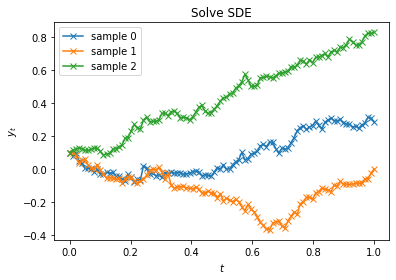

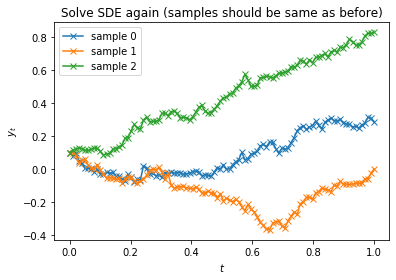

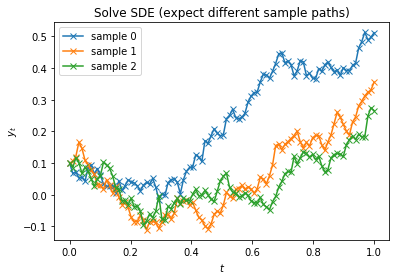

In [8]:
sde = SDE()
ts = torch.linspace(0, 1, T)
y0 = torch.zeros(batch_size, 1).fill_(0.1)  # (batch_size, d)

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='srk', bm=bm)
plt.figure()
plt.title('Solve SDE')
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='srk', bm=bm)
plt.figure()
plt.title('Solve SDE again (samples should be same as before)')
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

# Use a new BM sample, we expect different sample paths.
bm = BrownianPath(t0=0.0, w0=torch.zeros(batch_size, d))
with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='srk', bm=bm)
plt.figure()
plt.title('Solve SDE (expect different sample paths)')
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

### 4. Noise type of SDEs affects which solvers can be used and what strong orders can be attained

The supported noise types of this codebase are "diagonal", "additive", "scalar", and "general". The following is a simple summary of each type:
- "diagonal": The diffusion function is an elementwise function, with the output being the same dimension as the state (both $d$-dimensional). There are $d$ independent Brownian motions, each responsible for the noise of only a single state dimension.
- "additive": The diffusion function is a constant w.r.t. the state, i.e. the derivative of the diffusion function w.r.t. the state is 0. The output of the diffusion function is of size $(d, m)$, and the system has $m$ independent Brownian motions. The integral involving the Brownian motion can be loosely interpreted as integrating a sequence of matrix-vector products.
- "scalar": The diffusion function has output shape $(d, 1)$, and a single Brownian motion is shared across all state dimensions. 
- "general": The diffusion function has output shape $(d, m)$, and the system has $m$ independent Brownian motions.

It is tempting to use the noise type configuration "general" for all problems. However, since there's little known structure for these SDEs, high-order solvers are not possible, and the current codebase only supports the `euler` method. All three methods (`euler`, `milstein`, and `srk`) are supported for all remaining noise types.

Lastly, for modeling problems, our limited experience have found "diagonal" to be a good setting, where flexibility of models and tractability of numerical integration is rather well-balanced. 

### 5. Solving Stratonovich SDE

In [3]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=False)  # Scalar parameter.
        self.noise_type = "diagonal"
        self.sde_type = "stratonovich"
    
    def f(self, t, y):
        return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

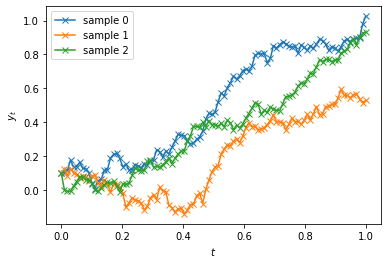

In [6]:
batch_size, d, T = 3, 1, 100
sde = SDE()
ts = torch.linspace(0, 1, T)
y0 = torch.zeros(batch_size, 1).fill_(0.1)  # (batch_size, d)

with torch.no_grad():
    ys = sdeint(sde, y0, ts, method='heun')  # (T, batch_size, d) = (100, 3, 1).

plt.figure()
for i in range(batch_size):
    plt.plot(ts, ys[:, i].squeeze(), marker='x', label=f'sample {i}')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()